In [34]:
import os
import time
import requests
import numpy as np
import pyarrow as pa
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.feature_extraction.text import CountVectorizer


In [35]:
ratings = pd.read_csv('upgraded_movielens_latest/filtered_ratings.csv', engine='pyarrow')
movies = pd.read_csv('upgraded_movielens_latest/upgraded_movies.csv', engine='pyarrow')
movies_w_title = pd.read_csv('movielens_latest/movies.csv', engine='pyarrow')

In [36]:
movies_w_title = movies_w_title.drop(columns=['genres'])
valid_movie_ids = set(movies['movieId'])
titles = movies_w_title[movies_w_title['movieId'].isin(valid_movie_ids)]
movies['movieId'] = movies['movieId'].astype(int)

In [37]:
print("Movies 'movieId' dtype:", movies['movieId'].dtype)
print("Ratings 'movieId' dtype:", ratings['movieId'].dtype)
print("Titles 'movieId' dtype:", titles['movieId'].dtype)

Movies 'movieId' dtype: int64
Ratings 'movieId' dtype: int64
Titles 'movieId' dtype: int64


In [38]:
movies = movies.sort_values('movieId', ascending=True)
titles = titles.sort_values('movieId', ascending=True)

In [39]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 33752010
Number of unique movieId's: 82129
Number of unique users: 330953
Average number of ratings per user: 101.98
Average number of ratings per movie: 410.96


In [40]:
print(f"Mean global rating: {round(ratings['rating'].mean(),3)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.542.
Mean rating per user: 3.7.


In [41]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]
# print()

,movieId,tag
5669,5805,overview: A 21st century sorceress (Hardman) a...


In [42]:
titles[titles['movieId'] == lowest_rated]

,movieId,title
5694,5805,Besotted (2001)


In [43]:
highest_rated = mean_ratings['rating'].idxmax()
print(highest_rated)
movies[movies['movieId'] == highest_rated]

31945


,movieId,tag
9603,31945,overview: Nina Davenport's journey through her...


In [44]:
titles[titles['movieId'] == highest_rated]

,movieId,title
9644,31945,Always a Bridesmaid (2000)


In [45]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
12408634,122184,31945,5.0,1553102189


In [46]:
"""suppose for movieId 1 , it will group all the ratings with movieId 1.
 In this case that group has 76813 ratings . It then take those 76813 rating then count them by count aggregate func
 basically len(group) which is 76813 in this example and mean them by mean aggregate func which is 3.893508"""

movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,76813,3.893508
2,30209,3.278179
3,15820,3.171271
4,3028,2.868395
5,15801,3.076957


In [47]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

Average number of ratings for a given movie: 410.96
Average rating for a given movie: 3.01


In [48]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.018635693173405

In [49]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.head()

,movieId,rating
0,1,3.888800
1,2,3.274566
2,3,3.167162
3,4,2.885197
4,5,3.075234


In [50]:
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_avg_ratings.head()

,movieId,bayesian_avg
0,1,3.888800
1,2,3.274566
2,3,3.167162
3,4,2.885197
4,5,3.075234


In [51]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [52]:
movie_stats.head(6)

,movieId,count,mean,bayesian_avg
0,1,76813,3.893508,3.888800
1,2,30209,3.278179,3.274566
2,3,15820,3.171271,3.167162
3,4,3028,2.868395,2.885197
4,5,15801,3.076957,3.075234
5,6,31850,3.862166,3.851298


In [53]:
movie_stats = movie_stats.merge(movies,on='movieId')
movie_stats.sort_values('bayesian_avg', ascending=False).head(2)

,movieId,count,mean,bayesian_avg,tag
314,318,122296,4.416792,4.412077,overview: Imprisoned in the 1940s for the doub...
835,858,75004,4.326603,4.319422,"overview: Spanning the years 1945 to 1955, a c..."


In [54]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,tag
3476,3593,5414,1.591245,1.691270,"overview: In the year 3000, man is no match fo..."
4648,4775,788,1.151015,1.787866,overview: A young woman is catapulted into pop...
11304,50798,1532,1.461488,1.788807,overview: When the Pevensie siblings each foll...
6440,6587,872,1.214450,1.789284,overview: Gigli is ordered to kidnap the psych...
9566,31698,847,1.241440,1.818881,"overview: Tim Avery, an aspiring cartoonist, f..."


In [55]:
ratings_copy = ratings
ratings = ratings.drop(columns=['timestamp'])
bayesian_ratings = ratings_copy.merge(movie_stats[["movieId", "bayesian_avg"]], on='movieId')
bayesian_ratings = bayesian_ratings.drop(columns=['timestamp', 'rating'])
bayesian_ratings = bayesian_ratings.sort_values('userId', ascending=True)
bayesian_ratings = bayesian_ratings.rename(columns={'bayesian_avg': 'rating'})

In [56]:
bayesian_ratings.head()

,userId,movieId,rating
0,1,1,3.888800
1201353,1,4246,3.372304
1220941,1,4306,3.743438
1279470,1,4699,2.971407
1280591,1,4886,3.833532


In [57]:
def create_X(df):
    
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    print(M)
    print(N)

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    print(X.shape)
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper



In [58]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

330953
82129
(330953, 82129)


In [59]:
X_b, user_mapper_b, movie_mapper_b, user_inv_mapper_b, movie_inv_mapper_b = create_X(bayesian_ratings)

330953
82129
(330953, 82129)


In [60]:
print("X.shape",X.shape)


svd = TruncatedSVD(n_components=300, n_iter=10)
Q = svd.fit_transform(X.T)
print("Q.shape",Q.shape)


svd = TruncatedSVD(n_components=300, n_iter=10)
Q_b = svd.fit_transform(X_b.T)
print("Q_b.shape",Q_b.shape)

X.shape (330953, 82129)
Q.shape (82129, 300)
Q_b.shape (82129, 300)


In [62]:
np.save('data/Q.npy', Q)
np.save('bayesian_data/Q_b.npy', Q_b)

In [ ]:
X = X.T
neighbour_ids = []

movie_ind = movie_mapper[1]
print(movie_ind)
movie_vec = X[movie_ind]
print(movie_vec.shape)
if isinstance(movie_vec, (np.ndarray)):
    movie_vec = movie_vec.reshape(1,-1)
    print(movie_vec.shape)
kNN = NearestNeighbors(n_neighbors=11, algorithm="brute", metric='cosine')
kNN.fit(X)
neighbour = kNN.kneighbors(movie_vec, return_distance=False)
for i in range(0,5):
    n = neighbour.item(i)
    print("n = ",n)
    neighbour_ids.append(movie_inv_mapper[n])
    print("movie_inv_mapper[n]   ",movie_inv_mapper[n])
neighbour_ids.pop(0)
print(neighbour_ids)

In [27]:
n_total = X.shape[0]*X.shape[1]
print("n_total",n_total)
n_ratings = X.nnz
print("n_ratings",n_ratings)
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")
n_ratings_per_user = X.getnnz(axis=1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

n_total 27180838937
n_ratings 33752010
Matrix sparsity: 0.12%
Most active user rated 33077 movies.
Least active user rated 1 movies.


In [28]:
n_total = X_b.shape[0]*X.shape[1]
print("n_total",n_total)
n_ratings = X_b.nnz
print("n_ratings",n_ratings)
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")
n_ratings_per_user = X.getnnz(axis=1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

n_total 27180838937
n_ratings 33752010
Matrix sparsity: 0.12%
Most active user rated 33077 movies.
Least active user rated 1 movies.


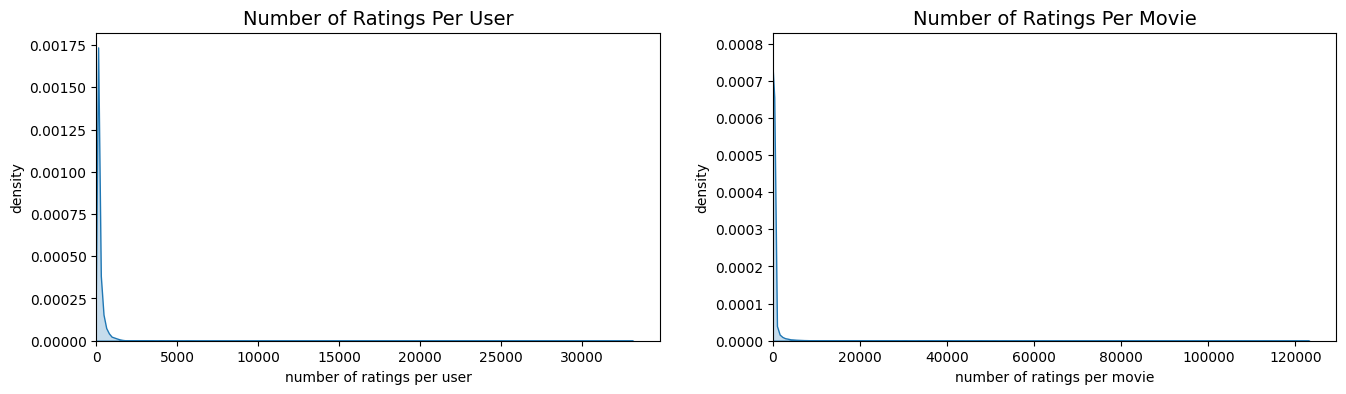

In [29]:
n_ratings_per_movie = X.getnnz(axis=0)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

(85407, 5000)


In [37]:
# cv = CountVectorizer(max_features=5000,stop_words='english')
# vector = cv.fit_transform(movies['tag']).toarray()
# print(vector.shape)
# movie_genres = np.array_split(vector, 4)
# print(movie_genres[0].shape)
# movie_genres1 = movie_genres[0]
# movie_genres2 = movie_genres[1]
# movie_genres3 = movie_genres[2]
# movie_genres4 = movie_genres[3]
# if not os.path.exists("cosine_similarities/cosine_sim11.npy"):
#     cosine_sim11 = cosine_similarity(movie_genres1, movie_genres1).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim11.npy', cosine_sim11)
#     del cosine_sim11
# if not os.path.exists("cosine_similarities/cosine_sim12.npy"):
#     cosine_sim12 = cosine_similarity(movie_genres1, movie_genres2).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim12.npy', cosine_sim12)
#     del cosine_sim12
# if not os.path.exists("cosine_similarities/cosine_sim13.npy"):
#     cosine_sim13 = cosine_similarity(movie_genres1, movie_genres3).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim13.npy', cosine_sim13)
#     del cosine_sim13
# if not os.path.exists("cosine_similarities/cosine_sim14.npy"):
#     cosine_sim14 = cosine_similarity(movie_genres1, movie_genres4).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim14.npy', cosine_sim14)
#     del cosine_sim14
# if not os.path.exists("cosine_similarities/cosine_sim21.npy"):
#     cosine_sim21 = cosine_similarity(movie_genres2, movie_genres1).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim21.npy', cosine_sim21)
#     del cosine_sim21
# if not os.path.exists("cosine_similarities/cosine_sim22.npy"):
#     cosine_sim22 = cosine_similarity(movie_genres2, movie_genres2).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim22.npy', cosine_sim22)
#     del cosine_sim22
# if not os.path.exists("cosine_similarities/cosine_sim23.npy"):
#     cosine_sim23 = cosine_similarity(movie_genres2, movie_genres3).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim23.npy', cosine_sim23)
#     del cosine_sim23
# if not os.path.exists("cosine_similarities/cosine_sim24.npy"):
#     cosine_sim24 = cosine_similarity(movie_genres2, movie_genres4).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim24.npy', cosine_sim24)
#     del cosine_sim24
# if not os.path.exists("cosine_similarities/cosine_sim31.npy"):
#     cosine_sim31 = cosine_similarity(movie_genres3, movie_genres1).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim31.npy', cosine_sim31)
#     del cosine_sim31
# if not os.path.exists("cosine_similarities/cosine_sim32.npy"):
#     cosine_sim32 = cosine_similarity(movie_genres3, movie_genres2).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim32.npy', cosine_sim32)
#     del cosine_sim32
# if not os.path.exists("cosine_similarities/cosine_sim33.npy"):
#     cosine_sim33 = cosine_similarity(movie_genres3, movie_genres3).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim33.npy', cosine_sim33)
#     del cosine_sim33
# if not os.path.exists("cosine_similarities/cosine_sim34.npy"):
#     cosine_sim34 = cosine_similarity(movie_genres3, movie_genres4).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim34.npy', cosine_sim34)
#     del cosine_sim34
# if not os.path.exists("cosine_similarities/cosine_sim41.npy"):
#     cosine_sim41 = cosine_similarity(movie_genres4, movie_genres1).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim41.npy', cosine_sim41)
#     del cosine_sim41
# if not os.path.exists("cosine_similarities/cosine_sim42.npy"):
#     cosine_sim42 = cosine_similarity(movie_genres4, movie_genres2).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim42.npy', cosine_sim42)
#     del cosine_sim42
# if not os.path.exists("cosine_similarities/cosine_sim43.npy"):
#     cosine_sim43 = cosine_similarity(movie_genres4, movie_genres3).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim43.npy', cosine_sim43)
#     del cosine_sim43
# if not os.path.exists("cosine_similarities/cosine_sim44.npy"):
#     cosine_sim44 = cosine_similarity(movie_genres4, movie_genres4).astype(np.float16)
#     np.save('cosine_similarities/cosine_sim44.npy', cosine_sim44)
#     del cosine_sim44

# if not os.path.exists("cosine_similarities/cosine_sim.npy"):
#     cosine_sim = np.block([
#         [np.load('cosine_similarities/cosine_sim11.npy'), np.load('cosine_similarities/cosine_sim12.npy'), np.load('cosine_similarities/cosine_sim13.npy'), np.load('cosine_similarities/cosine_sim14.npy')],
#         [np.load('cosine_similarities/cosine_sim21.npy'), np.load('cosine_similarities/cosine_sim22.npy'), np.load('cosine_similarities/cosine_sim23.npy'), np.load('cosine_similarities/cosine_sim24.npy')],
#         [np.load('cosine_similarities/cosine_sim31.npy'), np.load('cosine_similarities/cosine_sim32.npy'), np.load('cosine_similarities/cosine_sim33.npy'), np.load('cosine_similarities/cosine_sim34.npy')],
#         [np.load('cosine_similarities/cosine_sim41.npy'), np.load('cosine_similarities/cosine_sim42.npy'), np.load('cosine_similarities/cosine_sim43.npy'), np.load('cosine_similarities/cosine_sim44.npy')]
#     ])
#     np.save('cosine_similarities/cosine_sim.npy', cosine_sim)



In [39]:
def movie_finder(title):
    all_titles = titles['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [40]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [52]:
title_2_id = dict(zip(titles['title'], titles['movieId']))
id = title_2_id[title]
print(f"movieId for Jumanji: {id}")


movieId for Jumanji: 2
2


In [54]:
title_2_idx = dict(zip(titles['title'], list(titles.index)))
idx = title_2_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [62]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    print(title)
    idx = title_2_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(idx)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = []
    for i in sim_scores:
        print(i)
        similar_movies.append(i[0]) 
    rec = titles['title'].iloc[similar_movies].tolist()
    return rec

In [ ]:
print(get_content_based_recommendations('toy story'))

In [33]:
print("X.shape",X.shape)
svd = TruncatedSVD(n_components=100, n_iter=50)
Q = svd.fit_transform(X.T)
print("Q.shape",Q.shape)
svd = TruncatedSVD(n_components=100, n_iter=50)
Q_b = svd.fit_transform(X_b.T)
print("Q_b.shape",Q_b.shape)

X.shape (82129, 330953)
Q.shape (330953, 100)


NameError: name 'X_b' is not defined

In [ ]:
(82129, 330953)

(330953, )

In [ ]:
movie_titles = dict(zip(titles['movieId'], titles['title']))
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=15)
print("Movie_id",similar_movies)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

similar_movies = find_similar_movies(movie_id, X_b, movie_mapper_b, movie_inv_mapper_b, metric='cosine', k=15)
print("Movie_id",similar_movies)
movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

In [ ]:
def get_collab_based_recommendations(title_string, n_recommendations=15):
    title = movie_finder(title_string)
    print(title)
    idx = title_2_idx[title]
    movie_id = movie_inv_mapper[idx]
    similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=n_recommendations)
    movie_title = movie_titles[movie_id]
    rec = []
    for i in similar_movies:
        rec.append(movie_titles[i])
    return rec

In [ ]:
def get_collab_based_recommendation_b(title_string, n_recommendations=15):
    title = movie_finder(title_string)
    print(title)
    idx = title_2_idx[title]
    movie_id = movie_inv_mapper[idx]
    similar_movies = find_similar_movies(movie_id, Q_b.T, movie_mapper, movie_inv_mapper, metric='cosine', k=n_recommendations)
    movie_title = movie_titles[movie_id]
    rec = []
    for i in similar_movies:
        rec.append(movie_titles[i])
    return rec